In [1]:
import os
import time

import re
from pathlib import Path

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from PIL import Image

import cv2

import matplotlib.pyplot as plt
import seaborn as sns




In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
## Validate That GPU is Working

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

print(f"Tensorflow Version: {tf.version.VERSION}")

GPU device not found
Tensorflow Version: 2.7.0


In [ ]:
# Set a Few Parameters

In [6]:
BATCH_SIZE = 200
EPOCHS = 50
val_perc_split = 0.1
test_perc_split = 0.05
description ='ResNet50_RegionModel'

exported_models_location = Path('../workspace/gta_training/exported-models')
exported_models_location.mkdir(exist_ok=True)

FileNotFoundError: [Errno 2] No such file or directory: '../workspace/gta_training/exported-models'

In [ ]:
 # Read in Image Summary info
df_image_info = pd.read_parquet('/content/drive/My Drive/SCHOOL/ROB535/summarizedTrainImages.parquet')
df_image_info.head()

,filename,class,label,min_x,min_y,max_x,max_y
0,047b864f-0753-448b-9483-f990ae41abaf/0000_imag...,Vans,2,1530,336,1716,406
1,047b864f-0753-448b-9483-f990ae41abaf/0001_imag...,Coupes,1,856,415,900,450
2,047b864f-0753-448b-9483-f990ae41abaf/0002_imag...,Coupes,1,775,388,874,454
3,047b864f-0753-448b-9483-f990ae41abaf/0003_imag...,Sports,1,700,450,757,488
4,047b864f-0753-448b-9483-f990ae41abaf/0004_imag...,Sports,1,170,429,657,666


In [ ]:
# Load in Training Data

In [ ]:
X = np.load('/content/drive/My Drive/SCHOOL/ROB535/XTrain120by120SegmentedImages.npy')
Y = np.load('/content/drive/My Drive/SCHOOL/ROB535/YTrain120by120SegmentedImages.npy')
# Check if Order is teh same
orderSame = (df_image_info['label'].values == Y).all()
print(f"The Parquet file has the same order as the Numpy: {orderSame}")

# Update Height and Width
N, height, width, channels =  X.shape
yUnique = np.unique(Y)
NUnique = len(yUnique)

The Parquet file has the same order as the Numpy: True


In [ ]:
# Create Model Description For Creating Metrics Later
model_descript = f'{description}_{int(val_perc_split*100)}PercValAnd{int(test_perc_split*100)}Test_{BATCH_SIZE}Batch_{NUnique}classes_{width}by{height}'


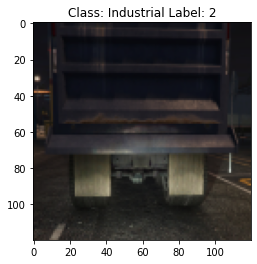

In [ ]:
# Plot Random Train Images
idx = np.random.randint(N)

className = df_image_info['class'].iloc[idx]
label = df_image_info['label'].iloc[idx]
test_img = X[idx,:,:,:]

plt.title(f"Class: {className} Label: {label}")
# plt.title(f"Class {Y[idx]}")
plt.imshow(test_img)
plt.show()

In [1]:
## Split the Training Data

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    horizontal_flip=True,
    validation_split=val_perc_split)

# One Hot Encode Y Labels
y = tf.keras.utils.to_categorical(Y, num_classes=NUnique)

# Use a utility from sklearn to split and shuffle your dataset.
XTrain, XTest, YTrain,YTest,df_image_info_train,df_image_info_test = train_test_split(X, y,df_image_info,test_size=test_perc_split)

datagen.fit(XTrain)

print('Training Images shape:', XTrain.shape)
NTrain,_,_,_ = XTrain.shape
print('Test Images shape:', XTest.shape)


print(f"There are {NUnique} unique classes.")



Training Images shape: (7194, 120, 120, 3)
Test Images shape: (379, 120, 120, 3)
There are 3 unique classes.


In [ ]:
# View a Sample of the Augmented Data

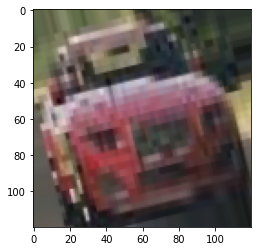

In [ ]:
sample_train_image, sample_class = next(datagen.flow(XTrain, YTrain, batch_size=1,subset='training'))
plt.imshow(sample_train_image[0,:,:,:].astype(int))
plt.show()

Create Model

In [ ]:
METRICS = [

      'accuracy',
      keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  base_model = tf.keras.applications.ResNet50(
    weights="imagenet", 
    include_top=False,
    input_shape=(height, width,3),
    
  )
  # Freeze all the layers Previously Learned
  for layer in base_model.layers[:2]:
      layer.trainable = False

  # Check the trainable status of the individual layers
  # for layer in base_model.layers:

  #     print(layer, layer.trainable)

  # Define Trainable Layers
  flatten_layer = layers.Flatten()
  dense_layer = layers.Dense(1024, activation='relu')
  drop_layer = layers.Dropout(0.2)
  prediction_layer = layers.Dense(NUnique, activation='softmax')



  # Add Base Model to New Layers
  model = models.Sequential([
      base_model,
      flatten_layer,
      dense_layer,
      drop_layer,
      prediction_layer
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-4),
      loss=keras.losses.categorical_crossentropy,
      metrics=metrics)

  return model

def plot_metrics(history,save_file =None):
  metrics = ['loss', 'prc', 'precision', 'recall']
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5, forward=True)
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
              linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
  if save_file is not None:
    plt.savefig(str(save_file))

def plot_cm(y_true, y_pred,save_file =None):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(10,10))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  if save_file is not None:
      plt.savefig(str(save_file))
def find_class_weights(Y):
  class_weights = {}

  y_max = np.max(Y)
  total = len(Y)

  for i in range(y_max + 1):
    NClass = sum(i == Y)
    weight_for_class = (1/NClass)*(total/2.0)
    class_weights[i] = weight_for_class

    print(f"Weight for class {i}: {weight_for_class:.2f}")

  return class_weights

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
callbacks_list = [early_stopping]

In [ ]:
# Train the model for 1 epoch from Numpy data
model = make_model()
history = model.fit(datagen.flow(XTrain, YTrain, batch_size=BATCH_SIZE,subset='training'), 
                    validation_data=datagen.flow(XTrain, YTrain, batch_size=BATCH_SIZE, subset='validation'),
                    epochs=EPOCHS,
                    callbacks=callbacks_list,               
                    class_weight=find_class_weights(np.argmax(YTrain,1))
                    )

Weight for class 0: 6.80
Weight for class 1: 0.79
Weight for class 2: 1.71
Epoch 1/50
26/26 [==============================] - 59s 2s/step - loss: 2.3322 - accuracy: 0.6766 - categorical_accuracy: 0.6766 - precision: 0.6829 - recall: 0.6663 - auc: 0.8314 - prc: 0.7104 - val_loss: 0.4308 - val_accuracy: 0.8317 - val_categorical_accuracy: 0.8317 - val_precision: 0.8390 - val_recall: 0.8261 - val_auc: 0.9522 - val_prc: 0.9149
Epoch 2/50
26/26 [==============================] - 49s 2s/step - loss: 0.3830 - accuracy: 0.8667 - categorical_accuracy: 0.8667 - precision: 0.8797 - recall: 0.8539 - auc: 0.9737 - prc: 0.9518 - val_loss: 0.3244 - val_accuracy: 0.8679 - val_categorical_accuracy: 0.8679 - val_precision: 0.8680 - val_recall: 0.8595 - val_auc: 0.9720 - val_prc: 0.9499
Epoch 3/50
26/26 [==============================] - 48s 2s/step - loss: 0.2669 - accuracy: 0.9046 - categorical_accuracy: 0.9046 - precision: 0.9107 - recall: 0.8975 - auc: 0.9857 - prc: 0.9734 - val_loss: 0.2570 - val_ac

In [ ]:
# Create Folder to Save Files

pathToModelSaveDir = Path(exported_models_location) / Path(model_descript)
pathToModelSaveDir.mkdir(exist_ok=True)

In [ ]:
# Save and Show Plot Metrics
val_loss_metrics ='metrics.png'
pathToModelMetricsImage = pathToModelSaveDir / Path(val_loss_metrics)
plot_metrics(history,pathToModelMetricsImage)

In [ ]:
# Show COnfusion Matrix of Hold Out Test Data

In [ ]:
test_predictions_baseline = model.predict(XTest, batch_size=BATCH_SIZE)

YTestPred = np.argmax(test_predictions_baseline,1)
baseline_results = model.evaluate(XTest, YTest,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()
YTestAct = np.argmax(YTest,1)

confusion_matrix_image ='test_data_confusion_matrix.png'
pathToCMImage = pathToModelSaveDir / Path(confusion_matrix_image)

plot_cm(YTestAct, YTestPred,pathToCMImage)

In [ ]:
test_images_location = '/content/drive/My Drive/SCHOOL/ROB535/PerceptionFinalProject/trainval'


In [ ]:
def find_detections_in_image(test_images_location,df_image_info_test,idx,YIncorrectTestPredScore):

    testFileName = df_image_info_test['filename'].iloc[idx]
    ymin,xmin,ymax,xmax = df_image_info_test.loc[:,['min_y','min_x','max_y','max_x']].iloc[idx].tolist()
    label = df_image_info_test['label'].iloc[idx]
    pathToTestFile = Path(test_images_location) / Path(testFileName)

    image = np.array(Image.open(str(pathToTestFile)))
    H,W, _ = image.shape

    ymin,xmin,ymax,xmax = int(ymin),int(xmin),int(ymax),int(xmax)
    
    # if category_index is not None:
    #     label = category_index[label]['name']

    # max_score = YIncorrectTestPredScore[idx]

    text = f"Class {label}"
    print(ymin)

    image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (50, 168, 164), 4)
    cv2.putText(image, text, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (50, 168, 164), 2) 
    plt.figure(figsize=(15,10))
    plt.imshow(image)
    plt.show()

In [ ]:
# Let's Look at Some Random Images That Were Incorrectly Classified

In [ ]:
filterToIncorrectTest = YTestAct != YTestPred
XIncorrectTest = XTest[filterToIncorrectTest,:,:,:]
YIncorrectTestAct = YTestAct[filterToIncorrectTest]
YIncorrectTestPred = YTestPred[filterToIncorrectTest]
YIncorrectTestPredScore = np.max(YTest[filterToIncorrectTest,:])


NTest,_,_,_ = XINcorrectTest.shape
print(f"There are incorrectly labeled classes {NTest}")

# PLot Random Train Images
idx = np.random.randint(NTest)



find_detections_in_image(test_images_location,df_image_info_test[filterToIncorrectTest],idx,YIncorrectTestPredScore)




test_img = XIncorrectTest[idx,:,:,:]
plt.figure(figsize=(15,10))

plt.title(f"Class Actual {YIncorrectTestAct[idx]}; Class Prediction {YIncorrectTestPred[idx]}")
plt.imshow(test_img)
plt.show()

In [ ]:
# Save Model
model.save(str(pathToModelSaveDir))

In [ ]:
# # Test Images on Best Model
XTest = np.load('/content/drive/My Drive/SCHOOL/ROB535/XTestthree_class_resnet50_v1_fpn_120821.npy')
GUID = np.load('/content/drive/My Drive/SCHOOL/ROB535/XTestGUIDthree_class_resnet50_v1_fpn_120821.npy')

In [ ]:
N, height, width, channels =  XTest.shape

In [ ]:
# Get Test Data Predictions
y_pred = model.predict(XTest)
y_hats = np.argmax(y_pred,1)

In [ ]:
# Create Pandas DataFrame
df_test_info = pd.DataFrame(zip(GUID,y_hats),columns=['guid/image','label'])
df_test_info.head()

In [ ]:
# Check Class Uniquenness
for l in df_test_info['label'].unique():
  print(f"{l}:\t{sum(l == df_test_info['label'].values)}")

In [ ]:
# Save Test Results to CSV
pathToCSVResults = pathToModelSaveDir / Path(f"{model_descript}SSD_OneClass120421Region.csv")
df_test_info.loc[:,['guid/image','label']].to_csv(pathToCSVResults,index=False)